# Descripción del proyecto

La cadena de gimnasios Model Fitness está desarrollando una estrategia de interacción con clientes basada en datos analíticos.
Tu tarea consiste en analizarlos y elaborar una estrategia de retención de clientes.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.model_selection import (
        KFold,
    StratifiedKFold,
    cross_val_score,
    TimeSeriesSplit
)
from sklearn.datasets import (
    make_classification,
    make_regression
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

In [3]:
# Leer el archivo y mostrar la info así como las primeras 5 filas

df = pd.read_csv('gym_churn_us.csv', sep=',')

display(df.info())

print()

display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
# verificación de nulos

display(df.isnull().sum())

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

con esta información puedo confirmar que el dataset está limpio y completo

In [5]:
# Estadísticas descriptivas (promedios, desviación estándar)

print(df.describe())

            gender  Near_Location      Partner  Promo_friends        Phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       Contract_period  Group_visits          Age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.00

In [6]:
# Comparar características por grupo (cancelación vs no cancelación)
# Agrupar por churn (0 = se quedó, 1 = se fue) y calcular promedio de cada variable

churn_mean = df.groupby('Churn').mean().T
print(churn_mean)

Churn                                       0           1
gender                               0.510037    0.510839
Near_Location                        0.873086    0.768143
Partner                              0.534195    0.355325
Promo_friends                        0.353522    0.183789
Phone                                0.903709    0.902922
Contract_period                      5.747193    1.728558
Group_visits                         0.464103    0.268615
Age                                 29.976523   26.989632
Avg_additional_charges_total       158.445715  115.082899
Month_to_end_contract                5.283089    1.662582
Lifetime                             4.711807    0.990575
Avg_class_frequency_total            2.024876    1.474995
Avg_class_frequency_current_month    2.027882    1.044546


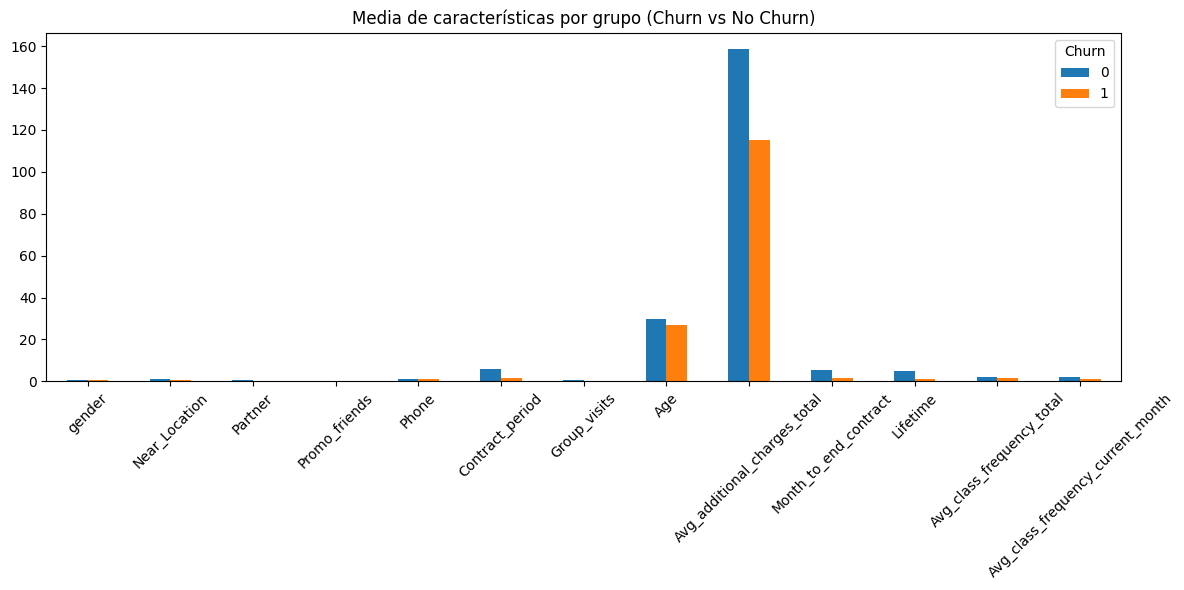

In [7]:
churn_mean.plot(kind='bar', figsize=(12,6), title='Media de características por grupo (Churn vs No Churn)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

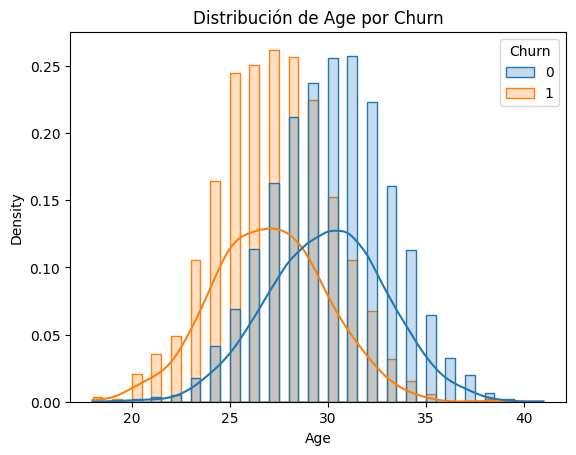

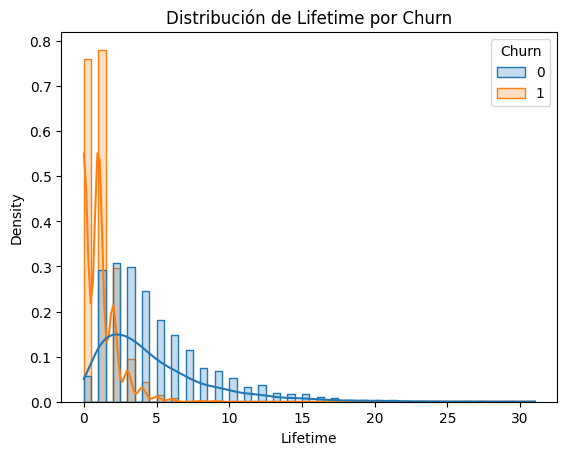

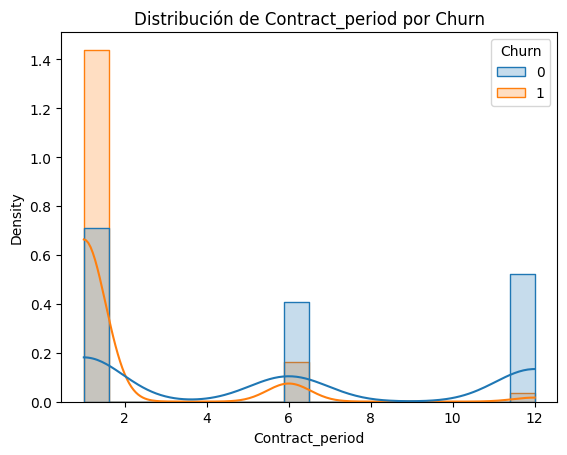

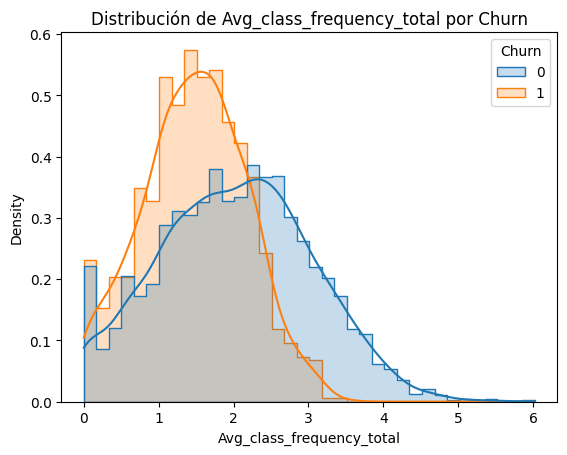

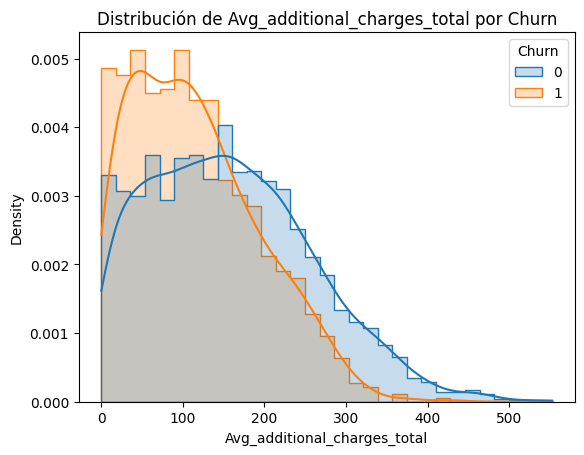

In [8]:
# Traza histogramas de barras y distribuciones de características para aquellas personas 
# que se fueron (cancelación) y para las que se quedaron.

# Algunas variables importantes para observar:
vars_to_plot = ['Age', 'Lifetime', 'Contract_period', 'Avg_class_frequency_total', 'Avg_additional_charges_total']

for var in vars_to_plot:
    sns.histplot(data=df, x=var, hue='Churn', kde=True, element='step', stat='density', common_norm=False)
    plt.title(f'Distribución de {var} por Churn')
    plt.show()

Estas variables tienen sentido desde una perspectiva de negocio y también estadística.

Interpretación Gráfico 1 (Age):
- Los clientes que no cancelaron (Churn = 0) están más concentrados entre los 28 y 35 años, con una curva de densidad que tiene su pico cerca de los 30 años.
- En cambio, los clientes que sí cancelaron (Churn = 1) tienden a estar en un rango ligeramente más joven, con un pico más notorio alrededor de los 25–26 años.

¿Qué sugiere esto?
Los clientes más jóvenes parecen tener mayor propensión a cancelar su membresía, mientras que los usuarios de edad media se quedan más tiempo.

Esto puede reflejar diferencias en estilo de vida, compromiso financiero o prioridades de los distintos grupos etarios. Quizá los clientes más jóvenes prueban el gimnasio pero no desarrollan un hábito constante.


Interpretación Gráfico 2 (Lifetime):
- La curva naranja, correspondiente a clientes que cancelaron (Churn = 1), tiene un pico pronunciado cerca de los 0 a 2 meses. 
  Eso indica que muchos de los que se dieron de baja lo hicieron muy pronto después de unirse.
- En contraste, la curva azul (Churn = 0) tiene una densidad más repartida y gana fuerza a medida que Lifetime aumenta, 
  especialmente a partir de los 3–4 meses en adelante.

¿Qué significa esto?
Los clientes nuevos (con poco tiempo en el gimnasio) son mucho más propensos a cancelar. 
A medida que pasa el tiempo y permanecen más meses, la probabilidad de abandono disminuye.

En resumen: el primer trimestre parece ser crítico para la retención. Si el cliente logra superar esa fase inicial, 
            hay más probabilidad de que se quede a largo plazo.

Interpretación Gráfico 3 (Contract_period):
- Los clientes que cancelaron están fuertemente concentrados en contratos cortos, especialmente el más pequeño 
  (probablemente 1 o 2 meses, según la codificación).
- En contraste, los clientes que no cancelaron están distribuidos de forma más balanceada, con una mayor densidad en  
  contratos largos (como 6 o 12 meses).

¿Qué nos dice esto?
Los contratos cortos se asocian fuertemente con mayor probabilidad de cancelación, mientras que los contratos largos tienden a retener más.

Esto tiene mucho sentido desde el negocio: un contrato largo suele implicar un mayor compromiso, y probablemente una tarifa más favorable, lo que ayuda a reducir la rotación.

Interpretación Gráfico 4 (Avg_class_frequency_total):
- La curva naranja (Churn = 1) tiene su pico en frecuencias bajas, alrededor de 0.4 a 0.6 visitas por semana. Esto indica que los clientes que asistían poco al gimnasio son quienes más tienden a abandonarlo.
- La curva azul (Churn = 0) se desplaza más a la derecha, con un pico hacia 1.5 visitas por semana, e incluso tiene presencia significativa en valores mayores.

Conclusión:
Los clientes que asisten regularmente al gimnasio tienen una menor probabilidad de cancelar su membresía, mientras que aquellos que asisten poco —menos de una vez por semana en promedio— son mucho más propensos al abandono.


Interpretación Gráfico 5 (Avg_additional_charges_total):
- La curva naranja (clientes que cancelaron) tiene un pico alto cerca de 0, lo que indica que la mayoría de estos 
  usuarios apenas   gastaron en servicios adicionales.
- En cambio, la curva azul (clientes que se quedaron) se extiende más hacia la derecha, con mayor densidad entre 
  aproximadamente 100 y 300 unidades monetarias.

Conclusión:
Los usuarios que gastan más en servicios adicionales del gimnasio tienen menos probabilidad de cancelación, mientras que quienes no aprovechan estos servicios tienden a abandonar más fácilmente.

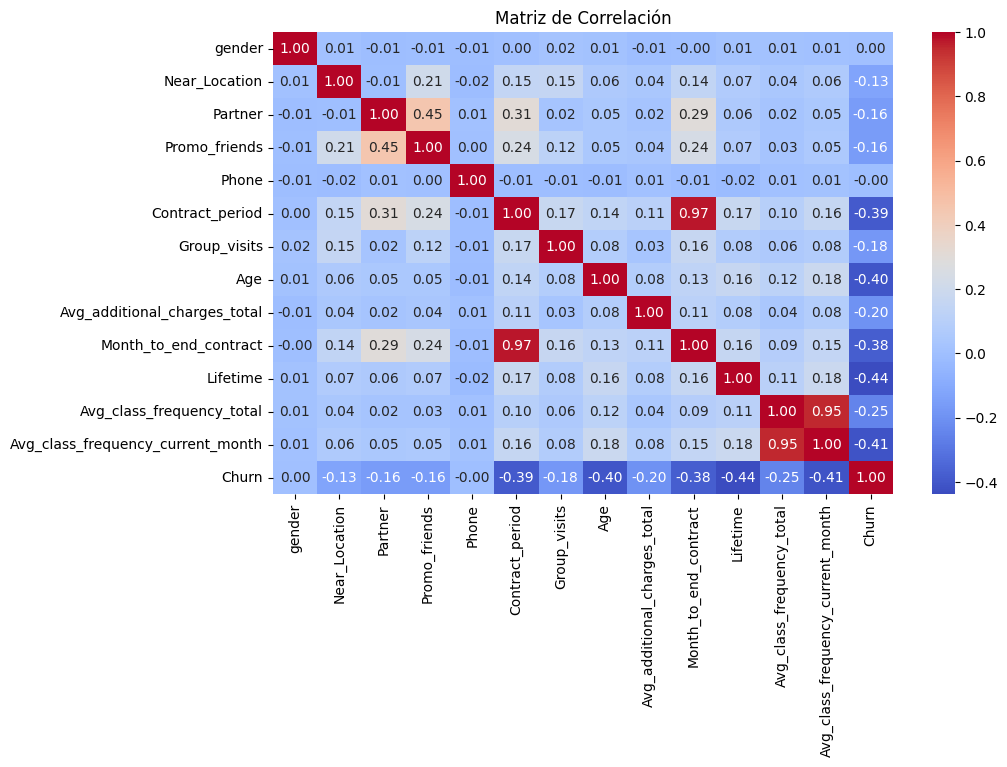

In [9]:
# Matriz de correlación

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

Variables como Lifetime, contract_period y nivel de uso del gimnasio están claramente relacionadas con el abandono. Este tipo de análisis es clave para elegir las mejores variables al entrenar un modelo predictivo de Churn.

In [10]:
#  Construir un modelo para predecir la cancelación de usuarios
# 1. Preparar X (características) e y (objetivo)

# Definimos X e y
X = df.drop(columns='Churn')
y = df['Churn']

In [11]:
#  2. Dividir los datos en entrenamiento y validación
#  ponemos valid = Validación  → para afinar hiperparámetros y evaluar desempeño mientras se desarrolla.


X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
#  3. Entrenar los modelos

# Regresión logística (log)
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

- La regresión logística es perfecta para explicar por qué y cómo un cliente cancela.

In [13]:
# Bosque aleatorio (rf)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

- El bosque aleatorio mejora la capacidad de predicción, sobre todo si hay patrones más complejos que no se capturan con la regresión.

In [14]:
# Evaluar con métricas

def evaluar_modelo(LogisticRegression,log_model , X_val, y_val):
    y_pred = log_model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    print(f"{LogisticRegression} → Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}")

In [15]:
def evaluar_modelo(RandomForestClassifier, rf_model, X_val, y_val):
    y_pred = rf_model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    print(f"{RandomForestClassifier} → Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}")

In [16]:
evaluar_modelo("Regresión Logística", log_model, X_valid, y_valid)
evaluar_modelo("Bosque Aleatorio", rf_model, X_valid, y_valid)

Regresión Logística → Accuracy: 0.92, Precision: 0.88, Recall: 0.83
Bosque Aleatorio → Accuracy: 0.93, Precision: 0.89, Recall: 0.83


 Interpretación:
- Ambos modelos tienen un recall igual (0.83), lo que significa que detectan con la misma eficacia a los clientes que se dan de baja.
- El Bosque Aleatorio supera ligeramente en exactitud (accuracy) y precisión:
- Accuracy: 93 % vs. 92 %
- Precision: 89 % vs. 88 %
- Eso sugiere que el modelo de Random Forest comete menos falsos positivos, es decir, no alerta innecesariamente a tantos clientes leales.

En términos generales, el Bosque Aleatorio ofrece un mejor rendimiento en este caso. Además, suele manejar mejor variables no lineales y relaciones complejas sin necesidad de escalar los datos.

In [17]:
#  1. Excluir Churn y estandarizar las variables numéricas

# Eliminamos la variable objetivo
df_cluster = df.drop(columns='Churn')

# Estandarizamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

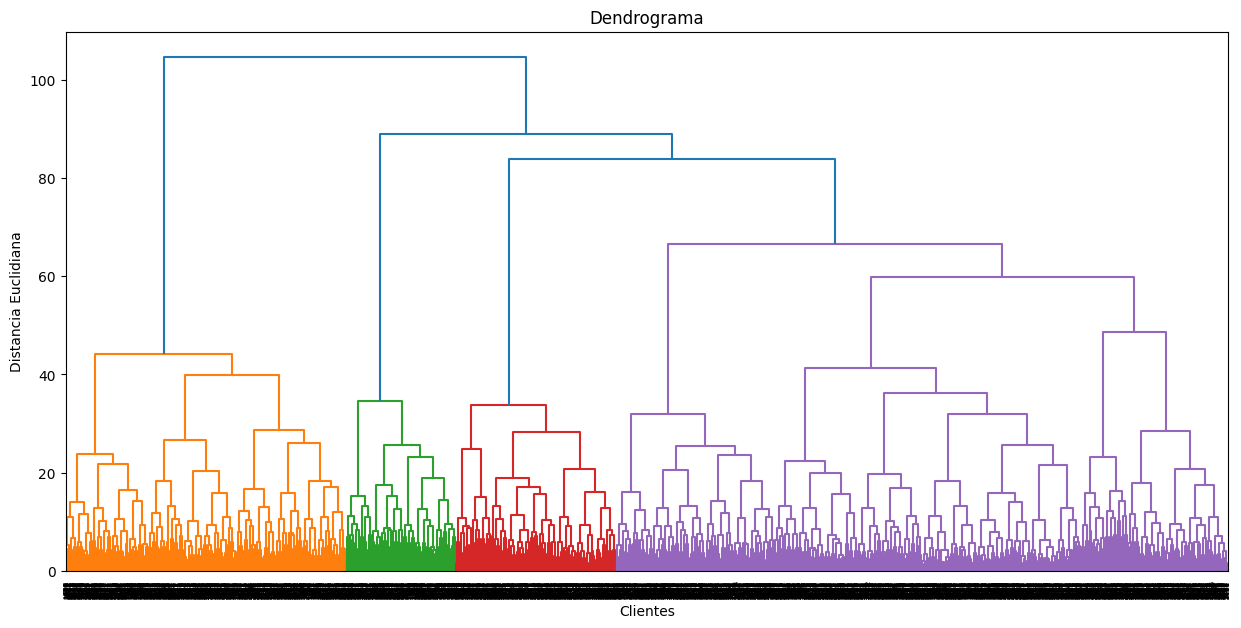

In [18]:
# 2. Dendrograma con linkage() para estimar número de clústeres

plt.figure(figsize=(15, 7))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.title("Dendrograma")
plt.xlabel("Clientes")
plt.ylabel("Distancia Euclidiana")
plt.show()

 Interpretación del dendrograma:
 
- El eje vertical representa la distancia entre grupos de clientes (cuanto más alta es la unión, más diferentes eran).
- El eje horizontal muestra cada cliente individual.
- Las ramas más bajas indican grupos muy similares entre sí.
- Al observar la altura a la que se forman los grandes cortes en el árbol, parece razonable hacer un corte horizontal 
  y definir aproximadamente 5 clústeres, como sugerido en el proyecto.

In [19]:
# 3. Entrenar K-means con 5 clústere

kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

In [20]:
#  4. Calcular valores medios de cada clúster

cluster_means = df.groupby('cluster').mean(numeric_only=True)
print(cluster_means)

           gender  Near_Location   Partner  Promo_friends     Phone  \
cluster                                                               
0        0.484801       0.698363  0.301637       0.007015  0.899454   
1        0.494471       0.947867  0.791469       0.998420  0.906793   
2        0.464396       0.913313  0.766254       0.493808  0.925697   
3        0.547794       0.937500  0.742647       0.424632  0.863971   
4        0.568233       0.878076  0.178971       0.048098  0.914989   

         Contract_period  Group_visits        Age  \
cluster                                             
0               1.733437      0.255651  28.074825   
1               2.740916      0.431280  28.903633   
2              10.495356      0.506192  30.091331   
3              11.194853      0.575368  29.720588   
4               2.120805      0.456376  29.993289   

         Avg_additional_charges_total  Month_to_end_contract  Lifetime  \
cluster                                                 

### perfiles por clúster:

Clúster 0 – Clientes nuevos y de bajo compromiso 

- Edad promedio baja (28 años), contrato corto (~1.7 meses)
- Poco tiempo en el gimnasio (Lifetime ≈ 2 meses), casi sin visitas ni gasto adicional
- Altísima proporción de usuarios con cero promociones entre amigos

Este grupo parece estar formado por quienes apenas probaron el servicio y probablemente están en riesgo de abandonarlo.

Clúster 1 – Alta retención social, pero poco uso 

- Altísimo porcentaje con partner (79 %), cercanía geográfica (94 %) y promo con amigos (99 %)
- Pero... ¡promedio de visitas casi nulo! (Avg_class_frequency_total ≈ 0.01)

Posiblemente gente que se inscribió por presión social o promociones pero que nunca se enganchó.

Clúster 2 – Comprometidos estables 

- Contrato medio (~10.5), visitas aceptables, gastos adicionales relativamente altos
- Lifetime promedio alto (4.7 meses), edad cercana a 30

Un clúster con señales de compromiso sostenido.

Clúster 3 – Los más comprometidos 

- Contrato más largo (11.2 meses) y Lifetime mayor
- Mayor frecuencia promedio (aunque sigue siendo baja en términos absolutos: ≈0.10)
- También tienen la media más alta de visitas grupales

Podrían ser los “fieles silenciosos”: no van mucho por semana, pero tienen años con el gimnasio y están en contrato largo.

Clúster 4 – Un perfil mixto interesante 

- Contrato corto, pero Lifetime largo (¿renovaciones sucesivas?)
- Frecuencia de uso aún baja, pero mayor gasto adicional
- Quizá perfiles con estancias largas pero sin hábitos de entrenamiento muy intensos

### Aspectos que llaman la atención:
- Clúster 1 tiene una participación altísima en “promo_friends”, “partner” y “near_location”… pero casi no asisten al gimnasio.
Es sorprendente que, a pesar de tener tantos factores sociales a favor (compañía, cercanía, recomendación), su frecuencia de asistencia sea prácticamente cero. Esto podría indicar que la motivación inicial no se convirtió en hábito.
- Clúster 0 parece agrupar a “clientes fugaces”.
Tienen la menor edad, contratos cortos, baja frecuencia y ningún gasto extra. Todo apunta a que son clientes que apenas prueban el servicio y podrían irse pronto.
- Clúster 3 destaca por la duración del contrato y tiempo como clientes, pero ¡su frecuencia de clases es baja!
Esto rompe con lo que esperaríamos: clientes antiguos y con contrato largo, pero con asistencia muy limitada. ¿Será por fidelidad emocional, promociones o simplemente desinterés reciente?
- El Avg_additional_charges_total es notoriamente distinto entre clústeres.
Algunos perfiles casi no gastan nada fuera de la mensualidad, mientras que otros llegan a invertir cantidades relevantes. Eso podría reflejar compromiso o simplemente estilo de consumo.

En resumen: hay grupos que se unieron por razones sociales y se desconectaron, otros que parecen fieles aunque poco activos, y algunos que simplemente están probando el servicio con bajo compromiso. Todo esto nos sirve para diseñar estrategias de retención personalizadas.

C:\Users\aleco\AppData\Local\Temp\ipykernel_15948\633450051.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster', y='Lifetime', palette='Set2')


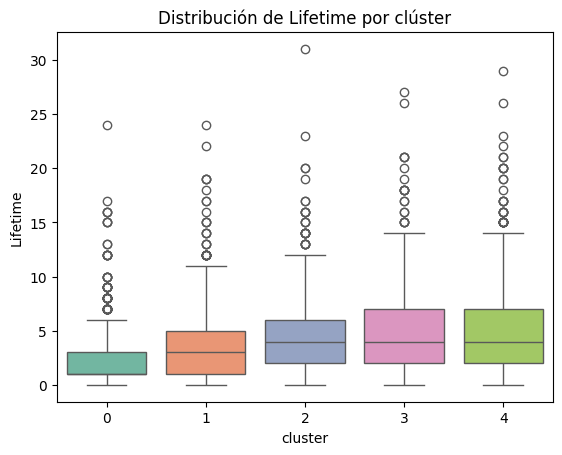

In [21]:
# 5. Graficar distribuciones por clústes
# Algunas variables importantes para observar:

sns.boxplot(data=df, x='cluster', y='Lifetime', palette='Set2')
plt.title("Distribución de Lifetime por clúster")
plt.show()

Hallazgos por clúster:

- Clúster 0: Tiene la mediana más baja, lo que indica que este grupo está formado principalmente por clientes nuevos o de muy corta duración. Además, su caja es estrecha: poca variabilidad dentro del clúster. Hay pocos valores extremos.
- Clúster 1: Mediana más elevada que la del clúster 0, pero todavía con una caja bastante comprimida. La mayoría de sus clientes llevan poco tiempo, pero hay algunos casos fuera del rango.
- Clúster 2: Tiene la mediana más alta y valores outliers muy alejados (uno cercano a Lifetime=30). Este grupo contiene los clientes más longevos y estables. También muestra bastante variabilidad.
- Clúster 3 y Clúster 4: Ambos tienen distribuciones similares con medianas medias. Lo interesante es que tienen muchos outliers superiores, lo que indica que hay clientes fieles mezclados con otros de permanencia baja o media

Conclusión:
El Clúster 2 destaca como el grupo de clientes más fieles, mientras que el Clúster 0 parece agrupar a quienes acaban de llegar (o se van rápido).


C:\Users\aleco\AppData\Local\Temp\ipykernel_15948\901745733.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster', y='Contract_period', palette='Set2')


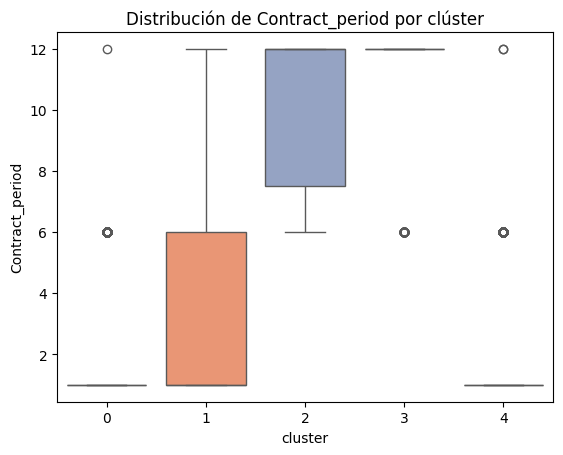

In [25]:
sns.boxplot(data=df, x='cluster', y='Contract_period', palette='Set2')
plt.title("Distribución de Contract_period por clúster")
plt.show()

Interpretación por clúster:

- Clúster 0: La caja está anclada cerca de 1, con baja dispersión. Esto indica que casi todos los clientes tienen contratos muy cortos. 
  Hay un valor atípico en 12 meses (alguien con un contrato largo en un grupo poco comprometido).
- Clúster 1: Tiene una mediana alrededor de 6 y mayor dispersión. Este grupo parece mezclar contratos cortos y medianos, con algunos 
  clientes incluso en contratos largos (outlier en 12).
- Clúster 2: Mediana cercana a 10–11 meses, y valores entre 8 y 12. Son clientes con compromisos contractuales altos, lo que puede 
  reflejar mayor fidelidad o intención de permanencia.
- Clúster 3: Todos están cerca de 12 meses, sin variación visible. Es el grupo más consistente y comprometido contractualmente. 
  Pura élite de contratos largos.
- Clúster 4: Similar al 0 → contratos cortos, con un único outlier largo. Perfil de entrada baja o temporales.

Conclusión:
Los clústeres 0 y 4 parecen reunir a los clientes con menos compromiso (contrato corto), mientras que los clústeres 2 y 3 agrupan a 
los más comprometidos (contratos largos). El clúster 1 queda como punto intermedio.

C:\Users\aleco\AppData\Local\Temp\ipykernel_15948\111944200.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster', y='Avg_class_frequency_total', palette='Set2')


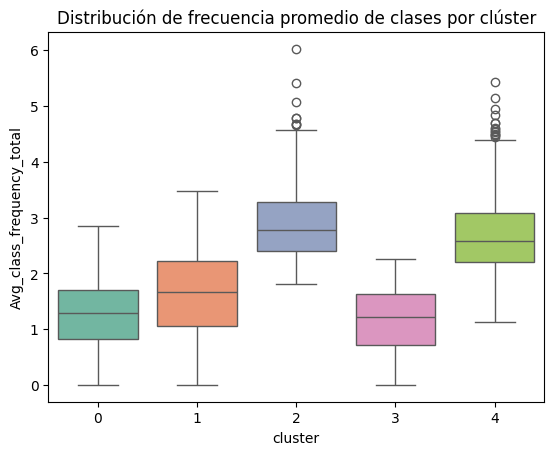

In [26]:
sns.boxplot(data=df, x='cluster', y='Avg_class_frequency_total', palette='Set2')
plt.title("Distribución de frecuencia promedio de clases por clúster")
plt.show()

 Interpretación por clúster:

- Clúster 0: Mediana alrededor de 2. Tiene un rango de valores de ~0 a 3.5. Eso indica una frecuencia moderada, 
  pero con bastantes clientes con asistencia baja.
- Clúster 1: Mediana muy parecida a la del clúster 0, pero con una caja más ancha. Esto refleja una mayor variabilidad 
  dentro del grupo: algunos asisten poco, otros bastante.
- Clúster 2: El clúster más activo de todos. Tiene una mediana cercana a 3 y una cola de outliers que llega hasta casi 
  6 clases por semana. Son personas que asisten de forma muy regular o intensiva.
- Clúster 3: Mediana por debajo de 2, muy cerca del mínimo. Tiene un rango más comprimido que los demás. Esto sugiere que 
  es un grupo menos activo en promedio, con frecuencia baja y menos variabilidad.
- Clúster 4: Mediana por encima de 2.5, y outliers que superan 5. Este grupo también tiene alta participación, aunque con 
  algo más de dispersión que el clúster 2.

Conclusión:
Los clústeres 2 y 4 destacan como los más comprometidos en términos de asistencia a clases, 
mientras que el clúster 3 muestra la menor frecuencia promedio.

In [24]:
#  3. Ver tasas de cancelación por clúster

df.groupby('cluster')['Churn'].mean().sort_values(ascending=False).apply(lambda x: f"{x * 100:.2f}%")

cluster
0    58.77%
1    28.59%
4    10.51%
3     4.23%
2     1.39%
Name: Churn, dtype: object

Interpretación:

- Clúster 0: el más problemático con casi 6 de cada 10 clientes que cancelan. Ya sabíamos que este grupo tenía contratos cortos, 
  poca asistencia y poco gasto adicional — ahora queda claro que también es el más volátil.

- Clúster 1: también con tasa elevada (~29 %), aunque bastante menor que el clúster 0. A pesar de factores sociales 
  (partner, promo_friends), parece que no logran comprometerse.

- Clústeres 4 y 3: muestran bajas tasas de cancelación, señal de buena retención. Son grupos con asistencia moderada o gasto 
  complementario.

- Clúster 2: el más fiel, con una tasa de cancelación ínfima (~1.4 %). Este grupo además mostraba alta frecuencia de uso y contratos 
  largos. 

Conclusiones:
Los clústeres 0 y 1 son propensos a abandonar. Son buenos candidatos para campañas de reactivación o seguimiento proactivo.
En cambio, los clústeres 2, 3 y 4 son los más leales — podrían ser embajadores de marca o incluso perfil de cliente ideal.

##  Segmentación de clientes por comportamiento y cancelación

| Clúster   | Perfil principal                        | Contrato / Asistencia    | Churn (%)   | Acción clave                        |
|-----------|-----------------------------------------|--------------------------|-------------|-------------------------------------|
| **0**     | Nuevos, poco activos, bajo compromiso   | Corto / Baja             | **58.77 %** | Activación rápida / onboarding      |
| **1**     | Sociales pero inactivos                 | Corto / Baja             | **28.59 %** | Campañas de uso / clases abiertas   |
| **4**     | Activos y con gasto adicional           | Medio / Alta             | **10.51 %** | Fidelización / beneficios extra     |
| **3**     | Contrato largo, baja asistencia         | Largo / Baja             | **4.23  %** | Reactivación suave / comunidad      |
| **2**     | Cliente ideal: activo y fiel            | Largo / Alta             | **1.39  %** | Recompensas / Embajador de marca    |